In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

In [40]:
#train = pd.read_csv('dataset-0510/train.csv')
#test  = pd.read_csv('dataset-0510/test.csv')

train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')
data  = pd.concat([train, test], axis=0)


#drop outlier
train.drop(train[(train['land_area'] > 1500) | (train['building_area'] >1000)].index, inplace= True)
'''
target_df = train.groupby(['city', 'town']).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()
target_df.columns = [i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in target_df.columns.tolist()]
target_df['total_price_median'] = np.log1p(target_df['total_price_median'])
target_df['total_price_mean'] = np.log1p(target_df['total_price_mean'])
target_df['price_land_rate_median'] = target_df['total_price_median'] / target_df['land_area_median']
target_df['price_building_rate_median'] = target_df['total_price_median'] / target_df['building_area_median']
target_df['price_land_rate_mean'] = target_df['total_price_mean'] / target_df['land_area_mean']
target_df['price_building_rate_mean'] = target_df['total_price_mean'] / target_df['building_area_mean']


combine_cols = ['city', 'town', 'price_land_rate_median', 'price_building_rate_median', 'total_price_median']
train = pd.merge(train, target_df[combine_cols], on =['city', 'town'], how='left')
test = pd.merge(test, target_df[combine_cols], on =['city', 'town'], how='left')

target_df = train.groupby('building_type')['total_price'].median().reset_index()
target_df['building_total_price'] = np.log1p(target_df['total_price'])
target_df.drop('total_price', axis =1, inplace = True)
train = pd.merge(train, target_df, on =['building_type'], how='left')
test = pd.merge(test, target_df, on =['building_type'], how='left')

train.loc[train['building_area'] == 4, 'parking_area'] = train.loc[train['building_area'] == 4, 'building_area'] / train.loc[train['building_area'] == 4, 'total_floor']
test.loc[train['building_area'] == 4, 'parking_area'] = test.loc[test['building_area'] == 4, 'building_area'] / test.loc[test['building_area'] == 4, 'total_floor']
'''
#drop_cols = [i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i]
#train.drop(['town'], axis = 1, inplace = True)
#test.drop(['town'], axis = 1, inplace = True)
#train.drop(drop_cols, axis = 1, inplace = True)
#test.drop(drop_cols, axis = 1, inplace = True)
gc.collect()

210

In [5]:
len(train.columns), len(test.columns)

(305, 305)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59989 entries, 0 to 59999
Columns: 305 entries, III_10 to building_use_10
dtypes: float64(98), int64(206), object(1)
memory usage: 140.1+ MB


In [7]:
def hit_score(preds, train_data):
    trues  = train_data.get_label()
    trues = np.expm1(trues)
    preds = np.expm1(preds)
    scores = ((np.absolute(preds - trues) / trues) <= 0.1)
    hit_score = np.sum(scores) / train_data.num_data()
    return 'Hit_score', hit_score, True


#categorical feature to one-hot
def one_hot(train, test, categorical_features):
    data = pd.concat([train, test], axis=0)
    for i in categorical_features:
        data = data.join(pd.get_dummies(data[i], prefix = i))
        data.drop(i, axis = 1, inplace =True)
    train = data[:60000]
    test  = data[60000:]
    return train, test

In [8]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [9]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [76]:
def xgb_model(split_num, train, test, stratified = False, if_one_hot = True):
    '''
    category_cols = ['location_2',
 'inter_btw_building_type_building_use',
 'inter_btw_building_type_building_material',
 'inter_btw_building_type_parking_way',
 'inter_btw_building_use_building_material',
 'inter_btw_building_use_parking_way',
 'inter_btw_building_material_parking_way']
 '''
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 100000, 'max_depth' : -1,       
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.1,  'subsample': .8,   'colsample_bytree': .8, 'device' : 'gpu', 'num_threads' : 8
    }
     
    features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
    print(len(features)) 
    
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=1000, early_stopping_rounds= 3000, categorical_feature=category_cols, feval = hit_score)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
        yhat = np.expm1(oof[val_idx])
        Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
        print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
        print('-'*30)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit ratye : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions, oof, feature_importance_df


In [81]:
def lgb_model(split_num, train, test, stratified = False, if_one_hot = True):
    
    category_cols = ['location_2']
    '''
    ,
 'inter_btw_building_type_building_use',
 'inter_btw_building_type_building_material',
 'inter_btw_building_type_parking_way',
 'inter_btw_building_use_building_material',
 'inter_btw_building_use_parking_way',
 'inter_btw_building_material_parking_way']
 '''
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 100000, 'max_depth' : -1,       
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.1,  'subsample': .8,   'colsample_bytree': .8, 'device' : 'gpu', 'num_threads' : 8
    }
     
    features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
    print(len(features)) 
    
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=1000, early_stopping_rounds= 3000, categorical_feature=category_cols, feval = hit_score)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
        yhat = np.expm1(oof[val_idx])
        Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
        print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
        print('-'*30)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit ratye : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions, oof, feature_importance_df


215
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.136761	training's Hit_score: 0.626444	valid_1's rmse: 0.198727	valid_1's Hit_score: 0.507333
[20000]	training's rmse: 0.099557	training's Hit_score: 0.75587	valid_1's rmse: 0.191788	valid_1's Hit_score: 0.532833
[30000]	training's rmse: 0.0780212	training's Hit_score: 0.845463	valid_1's rmse: 0.189564	valid_1's Hit_score: 0.547667
[40000]	training's rmse: 0.0640624	training's Hit_score: 0.903741	valid_1's rmse: 0.188725	valid_1's Hit_score: 0.557833
[50000]	training's rmse: 0.0542085	training's Hit_score: 0.9405	valid_1's rmse: 0.188338	valid_1's Hit_score: 0.563333
[60000]	training's rmse: 0.0469798	training's Hit_score: 0.96187	valid_1's rmse: 0.188196	valid_1's Hit_score: 0.566167
[70000]	training's rmse: 0.041533	training's Hit_score: 0.974481	valid_1's rmse: 0.188132	valid_1's Hit_score: 0.567333
[80000]	training's rmse: 0.0372828	training's Hit_score: 0.982574	valid_1's rmse: 0.188109	

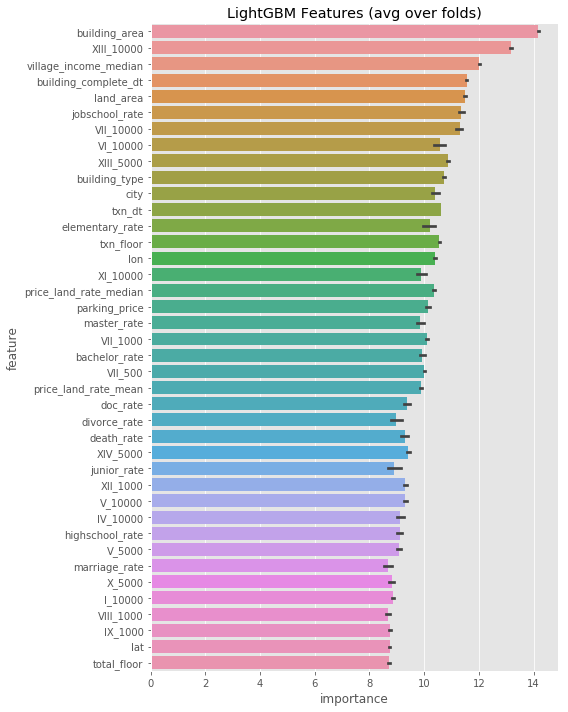

In [51]:
#7
begin = time.time()
prediction, oof = lgb_model(10, train, test, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

378
Training until validation scores don't improve for 3000 rounds.
[10000]	training's l2: 0.00170587	training's Hit_score: 0.975662	valid_1's l2: 0.0364589	valid_1's Hit_score: 0.584667
Early stopping, best iteration is:
[12481]	training's l2: 0.00106722	training's Hit_score: 0.989963	valid_1's l2: 0.0363284	valid_1's Hit_score: 0.59
fold 1 hit_score : 5900.0
------------------------------
Training until validation scores don't improve for 3000 rounds.
[10000]	training's l2: 0.00167148	training's Hit_score: 0.975293	valid_1's l2: 0.0356866	valid_1's Hit_score: 0.583667
Early stopping, best iteration is:
[13926]	training's l2: 0.00078156	training's Hit_score: 0.993262	valid_1's l2: 0.0355555	valid_1's Hit_score: 0.591333
fold 2 hit_score : 5913.333333333334
------------------------------
Training until validation scores don't improve for 3000 rounds.
[10000]	training's l2: 0.00169401	training's Hit_score: 0.976294	valid_1's l2: 0.0399502	valid_1's Hit_score: 0.587333
Early stopping, be

[15214]	training's l2: 0.000703243	training's Hit_score: 0.995139	valid_1's l2: 0.0360874	valid_1's Hit_score: 0.586195
fold 20 hit_score : 5861.953984661554
------------------------------
CV scrore : 0.1928944660132928
------------------------------
Hit ratye : 5854.740035673207
總共花：695.7716651479403 分
現在時間 ： 07-02-09-36


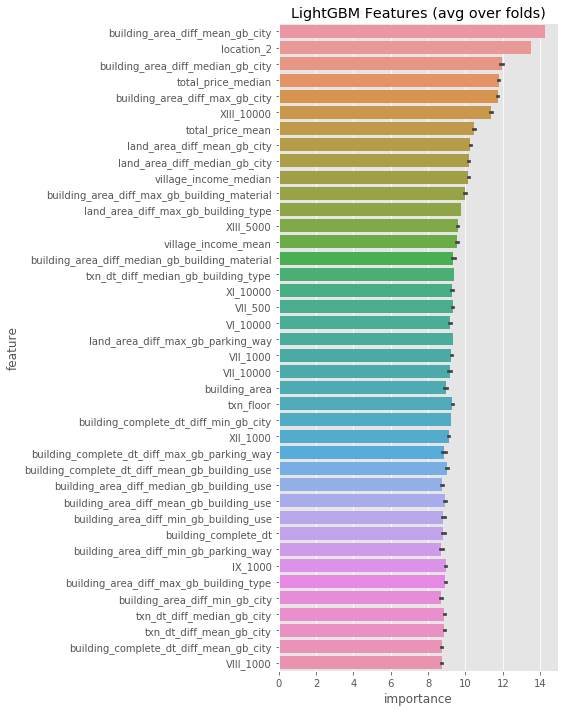

In [54]:
#7
begin = time.time()
prediction, oof = lgb_model(20, train, test, stratified = False)
prediction = np.expm1(prediction)
Submission(test['building_id'], prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))

378
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l2: 0.0253871	training's Hit_score: 0.547601	valid_1's l2: 0.0465793	valid_1's Hit_score: 0.471579
[2000]	training's l2: 0.0158117	training's Hit_score: 0.652417	valid_1's l2: 0.041229	valid_1's Hit_score: 0.517253
[3000]	training's l2: 0.010609	training's Hit_score: 0.737618	valid_1's l2: 0.0391326	valid_1's Hit_score: 0.537756
[4000]	training's l2: 0.00746677	training's Hit_score: 0.806872	valid_1's l2: 0.0381023	valid_1's Hit_score: 0.554592
[5000]	training's l2: 0.0054353	training's Hit_score: 0.862271	valid_1's l2: 0.037544	valid_1's Hit_score: 0.566928
[6000]	training's l2: 0.00405567	training's Hit_score: 0.904334	valid_1's l2: 0.0371982	valid_1's Hit_score: 0.574596
[7000]	training's l2: 0.003094	training's Hit_score: 0.934747	valid_1's l2: 0.0369906	valid_1's Hit_score: 0.577763
[8000]	training's l2: 0.00239611	training's Hit_score: 0.956381	valid_1's l2: 0.0368547	valid_1's Hit_score: 0.5817

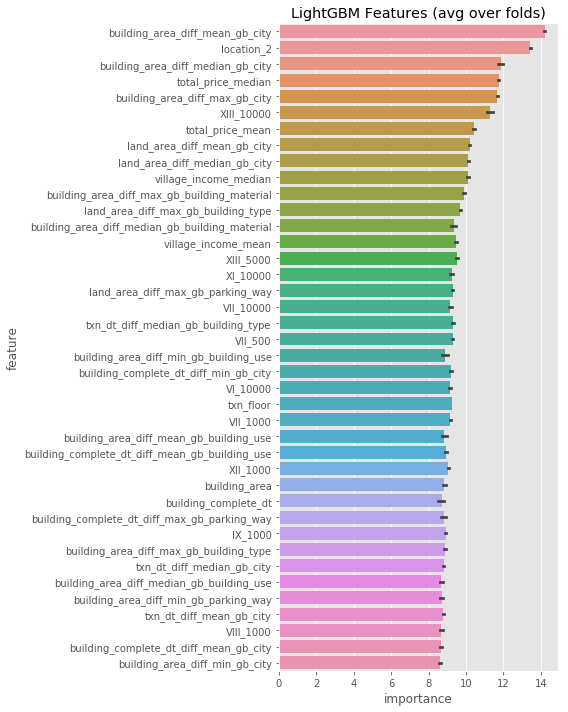

In [64]:
#7
begin = time.time()
prediction, oof, feature_importance_df = lgb_model(10, train, test, stratified = False)
prediction = np.expm1(prediction)
Submission(test['building_id'], prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))

377
Training until validation scores don't improve for 3000 rounds.
[10000]	training's l2: 0.00172152	training's Hit_score: 0.97575	valid_1's l2: 0.0354783	valid_1's Hit_score: 0.592
Early stopping, best iteration is:
[16460]	training's l2: 0.000589736	training's Hit_score: 0.996526	valid_1's l2: 0.0352916	valid_1's Hit_score: 0.595
fold 1 hit_score : 5950.0
------------------------------
Training until validation scores don't improve for 3000 rounds.
[10000]	training's l2: 0.00169331	training's Hit_score: 0.975083	valid_1's l2: 0.0357287	valid_1's Hit_score: 0.586
[20000]	training's l2: 0.000319497	training's Hit_score: 0.998158	valid_1's l2: 0.0355265	valid_1's Hit_score: 0.592667
Early stopping, best iteration is:
[20121]	training's l2: 0.000314686	training's Hit_score: 0.998175	valid_1's l2: 0.0355242	valid_1's Hit_score: 0.593667
fold 2 hit_score : 5936.666666666667
------------------------------
Training until validation scores don't improve for 3000 rounds.
[10000]	training's l2

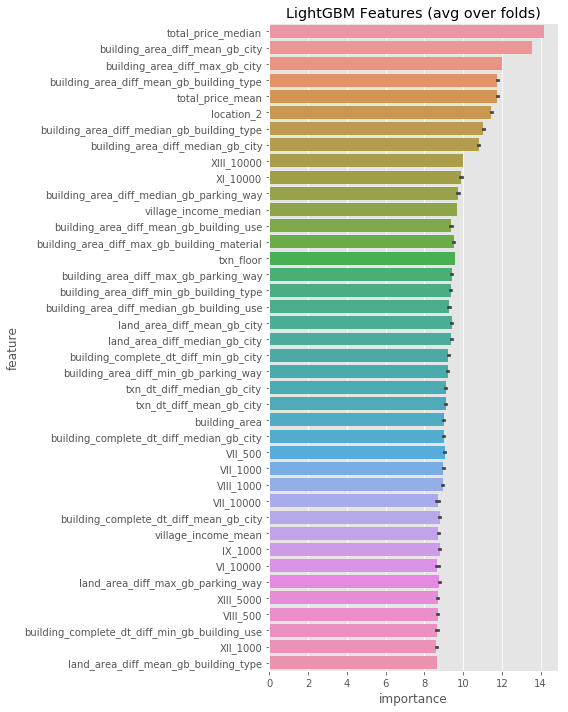

In [132]:
#7
begin = time.time()
cols = [i for i in cols ]
prediction, oof, feature_importance_df = lgb_model(20, train, test, stratified = False)
prediction = np.expm1(prediction)
Submission(test['building_id'], prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))

In [45]:
#7
begin = time.time()
prediction, oof, feature_importance_df = lgb_model(10, train, test, stratified = False)
prediction = np.expm1(prediction)
Submission(test['building_id'], prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))

307
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.212107	training's Hit_score: 0.448157	valid_1's rmse: 0.235034	valid_1's Hit_score: 0.426238
[2000]	training's rmse: 0.180859	training's Hit_score: 0.502538	valid_1's rmse: 0.214745	valid_1's Hit_score: 0.470745
[3000]	training's rmse: 0.163763	training's Hit_score: 0.535081	valid_1's rmse: 0.207149	valid_1's Hit_score: 0.487748
[4000]	training's rmse: 0.150985	training's Hit_score: 0.564345	valid_1's rmse: 0.20271	valid_1's Hit_score: 0.49975
[5000]	training's rmse: 0.140488	training's Hit_score: 0.591795	valid_1's rmse: 0.199658	valid_1's Hit_score: 0.508751
[6000]	training's rmse: 0.13163	training's Hit_score: 0.618707	valid_1's rmse: 0.197449	valid_1's Hit_score: 0.513252
[7000]	training's rmse: 0.123997	training's Hit_score: 0.644119	valid_1's rmse: 0.19568	valid_1's Hit_score: 0.520253
[8000]	training's rmse: 0.117292	training's Hit_score: 0.667957	valid_1's rmse: 0.194265	valid_1's Hit_

[21000]	training's rmse: 0.0667728	training's Hit_score: 0.888979	valid_1's rmse: 0.197686	valid_1's Hit_score: 0.552425
[22000]	training's rmse: 0.0644494	training's Hit_score: 0.899574	valid_1's rmse: 0.197475	valid_1's Hit_score: 0.554592


KeyboardInterrupt: 

In [141]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:200].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

In [110]:
len(train) 5878

59989

In [125]:
[i for i in cols if 'price' in i]

['total_price_median',
 'total_price_mean',
 'price_land_rate_mean',
 'price_land_rate_median',
 'parking_price_every_area']

In [98]:
qq = pd.concat([train,pd.DataFrame({'preds' : np.expm1(oof)})], axis=1)

In [104]:
cols = ['city', 'total_floor', 'I_MIN', 'II_MIN', 'III_MIN', 'IV_MIN', 'V_MIN', 'VI_MIN', 'VII_MIN', 'VIII_MIN', 'IX_MIN', 'X_MIN', 'XI_MIN', 'XII_MIN', 'XIII_MIN', 'XIV_MIN']
qq['is_duplicated'] = 0
qq.loc[qq[cols].duplicated(keep = False), 'is_duplicated'] = 1


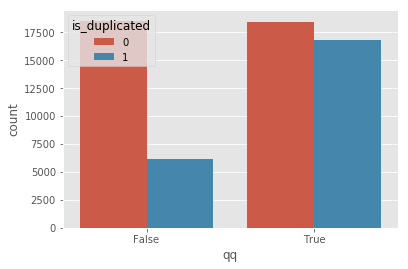

In [108]:
sns.countplot(qq['qq'], hue= qq['is_duplicated'])

In [106]:
qq['qq'] = np.abs(qq['total_price'] - qq['preds']) / qq['total_price'] < 0.1

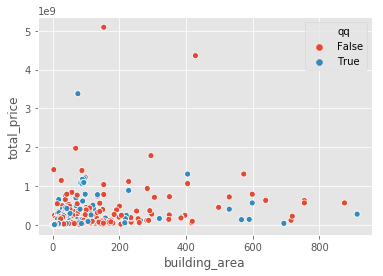

In [100]:
sns.scatterplot(qq['building_area'], qq['total_price'], hue= qq['qq'])

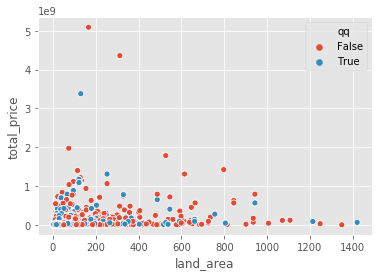

In [101]:
sns.scatterplot(qq['land_area'], qq['total_price'], hue= qq['qq'])

In [45]:
train.drop(train[(train['land_area'] > 1500) | (train['building_area'] >1000)].index, inplace= True)

In [21]:
gc.collect()

224

# Record

In [ ]:
1# cv :   0.20573  hit_rate :  5054   public : 5113   note : without Fe set n_estimators = 10,000
1.1# cv : 0.20580  hit_rate :  5045   public :        note : without Fe set n_estimators = 10,000 drop village
1.2# cv : 0.20352  hit_rate :  5075   public :        note : without Fe set n_estimators = 10,000 drop village one-hot
1.3# cv : 0.20570  hit_rate :  5056   public :        note : without Fe set n_estimators = 10,000 drop with category_features

# FE and use category_features   CV : 0.20355     hit_rate : 5056  with n_estimators = 10000
# FE and use one_hot             CV : 0.20402     hit_rate : 5079  with n_estimators = 10000

# FE and use one_hot             CV : 0.20336     hit_rate : 5088  with n_estimators = 10000 fillna mean 
# FE and use category_features   CV : 0.20320     hit_rate : 5104  with n_estimators = 10000 fillna mean

# FE and use one_hot             CV : 0.20342     hit_rate : 5089  with n_estimators = 10000 fillna median 
# FE and use category_features   CV : 0.2032     hit_rate : 5097  with n_estimators = 10000 fillna median 

# FE and use one_hot             CV : 0.20342     hit_rate : 5089  with n_estimators = 10000 add min I、II...
# FE and use category_features   CV : 0.20362     hit_rate : 5152.0  with n_estimators = 10000  add min I、II...

2#    cv : 0.19764  hit_rate :         public : 5737          note : without FE set n_estimators = 1,000,000
2.1#  cv : 0.19576  hit_rate : 5634    public : 5803.8749     note : FE set n_estimators = 1,000,000 with one-hot
2.2#  cv : 0.19582  hit_rate : 5622    public : 5803.8754     note : FE set n_estimators = 1,000,000 with category_features



3# cv : 0.20471  hit_rate :  5063   public :          note :  FE set n_estimators = 10,000  without one-hot
4# cv : 0.20536  hit_rate :  5028   public :          note :  FE set n_estimators = 10,000  with one-hot    drop village
5# cv : 0.20445  hit_rate :  5081   public :          note :  FE set n_estimators = 10,000  with one-hot   
6# cv : 0.20352  hit_rate :  5075   public : 3237     note :  FE set n_estimators = 10,000  with one-hot   combine city、village and groupby encoding

7# cv : 0.19362  hit_rate :  5703   public : 5857     note :  just target-encoding and 10-fold


In [16]:
train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')
data  = pd.concat([train, test], axis=0)
len(data.drop_duplicates())
gc.collect()

4622

In [25]:
len(test[~test[cols].duplicated(keep = False)])

9018

38722

In [26]:
len(data[~data[cols].duplicated(keep = False)])

42880

In [21]:
len(data[~data[cols].duplicated(keep = False)])

42880

In [28]:
len(test[test[cols].duplicated(keep = False)])


982

In [54]:
train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')
data  = pd.concat([train, test], axis=0)
cols = ['city', 'town', 'village', 'building_type', 'total_floor', 'XIV_MIN', 'building_complete_dt']
data = data[data[cols].duplicated(keep = False)]
train = data[:24080]
test = data[24080:]


target_df = train.groupby(cols).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()

target_df.columns = [i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in target_df.columns.tolist()]

target_df['total_price_median'] = np.log1p(target_df['total_price_median'])
target_df['total_price_mean'] = np.log1p(target_df['total_price_mean'])
target_df['price_land_rate_median'] = target_df['total_price_median'] / target_df['land_area_median']
target_df['price_building_rate_median'] = target_df['total_price_median'] / target_df['building_area_median']
target_df['price_land_rate_mean'] = target_df['total_price_mean'] / target_df['land_area_mean']
target_df['price_building_rate_mean'] = target_df['total_price_mean'] / target_df['building_area_mean']

combine_cols = [ 'price_land_rate_median', 'price_building_rate_median', 'total_price_median', 'total_price_mean', 'price_land_rate_mean', 'price_building_rate_mean'] + cols
train = pd.merge(train, target_df[combine_cols], on =cols, how='left')
test = pd.merge(test, target_df[combine_cols], on =cols, how='left')


In [82]:
#7
begin = time.time()

combine_cols += ['location_2']

prediction, oof, feature_importance_df = lgb_model(10, train, test, stratified = False)
prediction = np.expm1(prediction)
Submission(test['building_id'], prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))

382
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.0979799	training's Hit_score: 0.774686	valid_1's rmse: 0.137759	valid_1's Hit_score: 0.725914
[2000]	training's rmse: 0.081845	training's Hit_score: 0.830611	valid_1's rmse: 0.134241	valid_1's Hit_score: 0.744186
[3000]	training's rmse: 0.0722367	training's Hit_score: 0.869094	valid_1's rmse: 0.133706	valid_1's Hit_score: 0.75
[4000]	training's rmse: 0.0649964	training's Hit_score: 0.897887	valid_1's rmse: 0.133697	valid_1's Hit_score: 0.753738
[5000]	training's rmse: 0.0590613	training's Hit_score: 0.920589	valid_1's rmse: 0.13369	valid_1's Hit_score: 0.755814
[6000]	training's rmse: 0.0541122	training's Hit_score: 0.939046	valid_1's rmse: 0.133862	valid_1's Hit_score: 0.760382
Early stopping, best iteration is:
[3396]	training's rmse: 0.069177	training's Hit_score: 0.882337	valid_1's rmse: 0.133624	valid_1's Hit_score: 0.752907


KeyError: "['mean'] not in index"

In [77]:
new_features = pd.read_csv('dataset-0510/new_features.csv')
new_features_df = new_features[new_features['building_id'].isin(train['building_id'])]

In [57]:
len(new_features_df)

24080

In [70]:
train = pd.merge(train, new_features_df, how ='left', on ='building_id')

In [63]:
len(train['building_id'])

24080

In [74]:
train['mean'] = np.log1p(train['mean'])